In [1]:
!pip install pdpbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
import shap
from pdpbox import pdp
import warnings
warnings.filterwarnings('ignore')
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import shapiro


In [3]:
cs_train = pd.read_csv('cs-training.csv')
cs_train = cs_train.iloc[:50000].copy()
print("\nDataset dimensions:", cs_train.shape)
print("\nColumn information:")
for col in cs_train.columns:
    print(f"- {col}: {cs_train[col].dtype}")


Dataset dimensions: (50000, 12)

Column information:
- Unnamed: 0: int64
- SeriousDlqin2yrs: int64
- RevolvingUtilizationOfUnsecuredLines: float64
- age: int64
- NumberOfTime30-59DaysPastDueNotWorse: int64
- DebtRatio: float64
- MonthlyIncome: float64
- NumberOfOpenCreditLinesAndLoans: int64
- NumberOfTimes90DaysLate: int64
- NumberRealEstateLoansOrLines: int64
- NumberOfTime60-89DaysPastDueNotWorse: int64
- NumberOfDependents: float64


In [4]:
cs_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
cs_train.isnull().sum()


,0
Unnamed: 0,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,10004
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0


In [6]:
if 'Unnamed: 0' in cs_train.columns:
    cs_train.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
cs_train['MonthlyIncome'].fillna(cs_train['MonthlyIncome'].median(), inplace=True)
cs_train['NumberOfDependents'].fillna(cs_train['NumberOfDependents'].median(), inplace=True)

In [8]:
cs_train.isnull().sum()


,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,0
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0


In [9]:
cs_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.066940,5.140053,52.210200,0.427700,360.093462,6365.310820,8.420480,0.276600,1.016280,0.249020,0.738380
std,0.249921,220.446381,14.792364,4.290205,2070.454856,7300.202296,5.128751,4.267207,1.128202,4.254016,1.110207
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029884,41.000000,0.000000,0.175006,3912.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.157143,52.000000,0.000000,0.367364,5388.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.563820,63.000000,0.000000,0.876061,7355.250000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,29110.000000,107.000000,98.000000,326442.000000,629000.000000,58.000000,98.000000,54.000000,98.000000,20.000000


In [10]:
max_debt_ratio = cs_train['DebtRatio'].quantile(0.99)
cs_train['DebtRatio'] = cs_train['DebtRatio'].apply(lambda x: max_debt_ratio if x > max_debt_ratio else x)

max_revolving = cs_train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)
cs_train['RevolvingUtilizationOfUnsecuredLines'] = cs_train['RevolvingUtilizationOfUnsecuredLines'].apply(
    lambda x: max_revolving if x > max_revolving else x
)


print(cs_train.describe())

       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines           age  \
count      50000.000000                          50000.000000  50000.000000   
mean           0.066940                              0.323073     52.210200   
std            0.249921                              0.353953     14.792364   
min            0.000000                              0.000000     21.000000   
25%            0.000000                              0.029884     41.000000   
50%            0.000000                              0.157143     52.000000   
75%            0.000000                              0.563820     63.000000   
max            1.000000                              1.086390    107.000000   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                          50000.000000  50000.000000   50000.000000   
mean                               0.427700    323.357622    6365.310820   
std                                4.290205    921.532967   

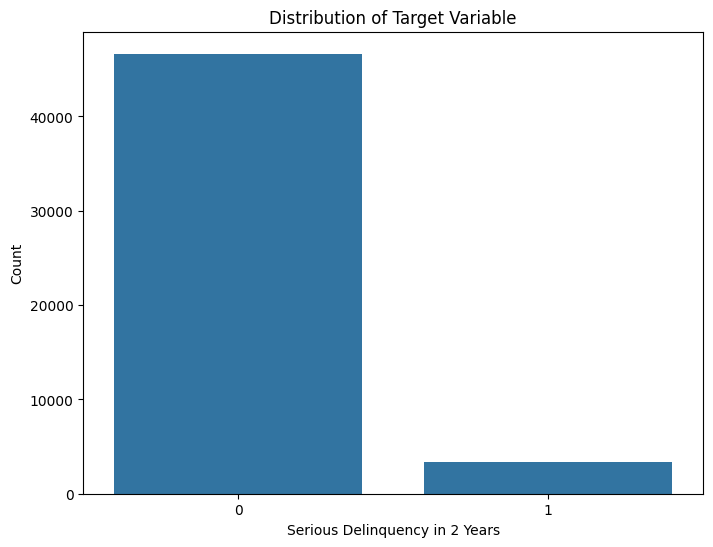

Target Variable Distribution:
SeriousDlqin2yrs
0    93.306
1     6.694
Name: count, dtype: float64


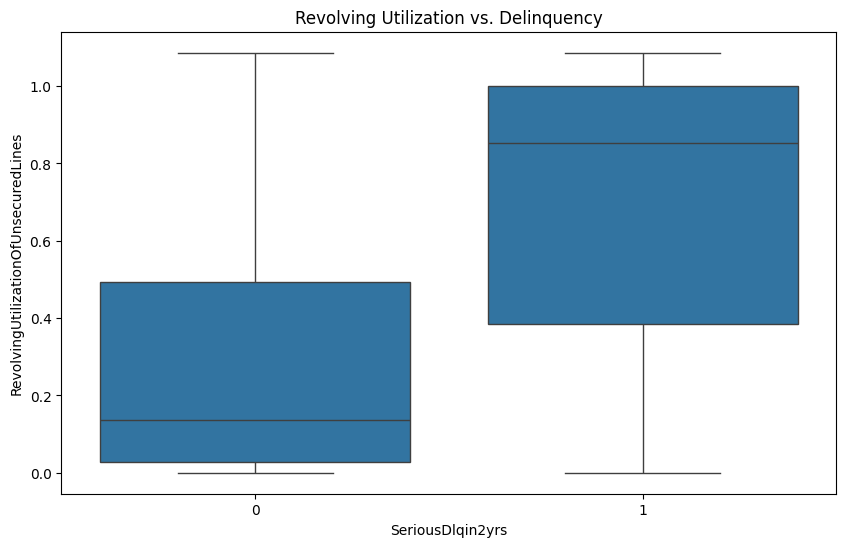

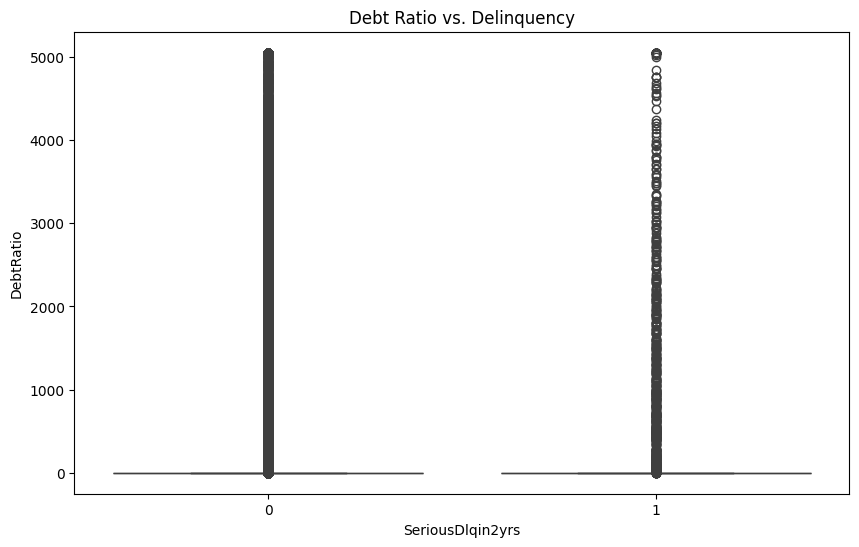

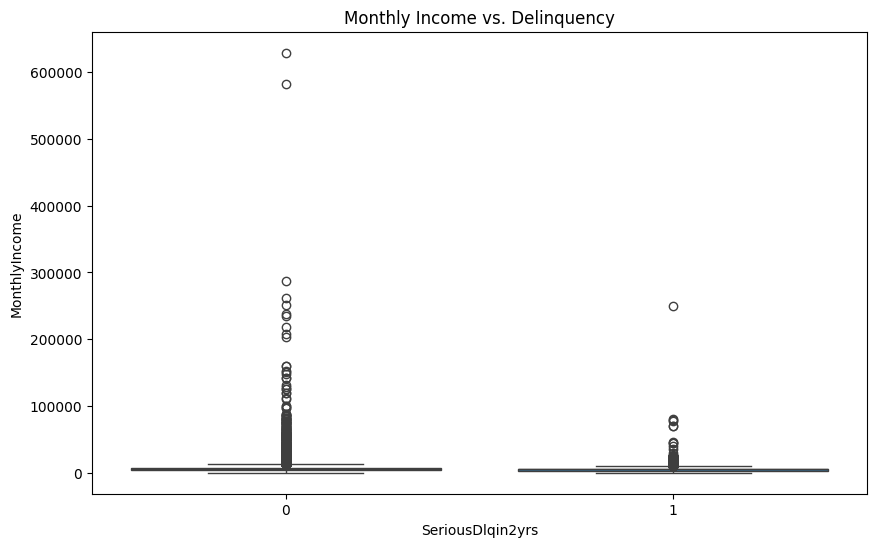

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='SeriousDlqin2yrs', data=cs_train)
plt.title('Distribution of Target Variable')
plt.xlabel('Serious Delinquency in 2 Years')
plt.ylabel('Count')
plt.show()

target_counts = cs_train['SeriousDlqin2yrs'].value_counts()
target_percentages = target_counts / len(cs_train) * 100
print(f"Target Variable Distribution:\n{target_percentages}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines', data=cs_train)
plt.title('Revolving Utilization vs. Delinquency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='DebtRatio', data=cs_train)
plt.title('Debt Ratio vs. Delinquency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=cs_train)
plt.title('Monthly Income vs. Delinquency')
plt.show()



Analyzing feature distributions:


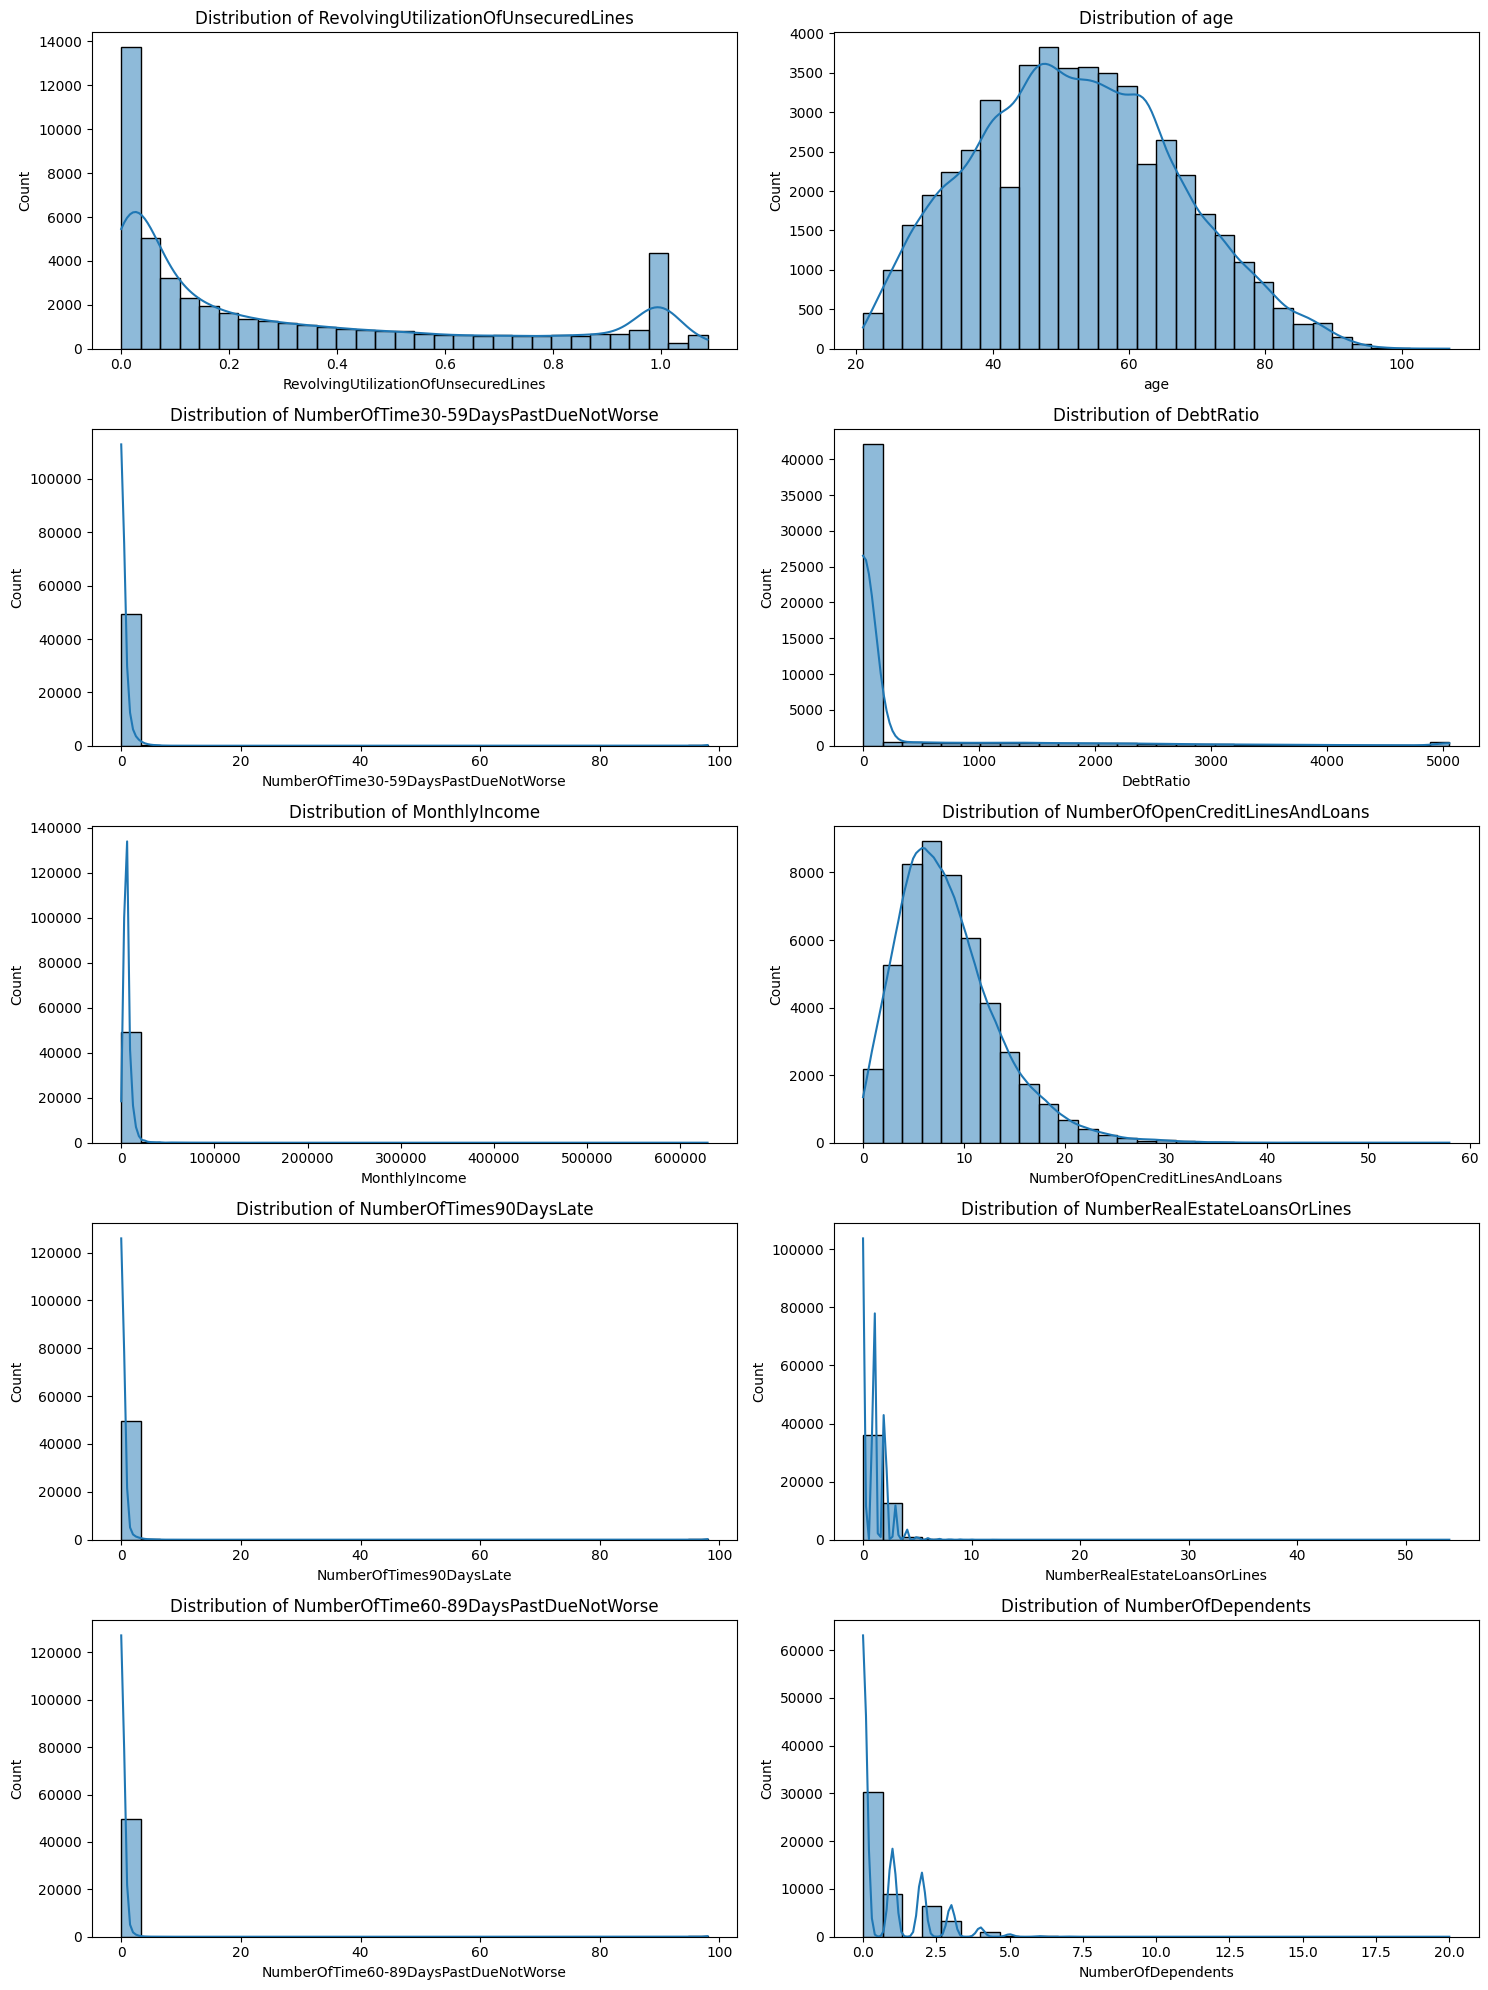

In [12]:
def plot_histograms(df, columns, bins=30):
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        if i < len(axes):
            sns.histplot(df[col], bins=bins, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')

    # Hide any unused subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Separate numerical and categorical features
numerical_features = cs_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('SeriousDlqin2yrs')  # Remove target variable

print("\nAnalyzing feature distributions:")
plot_histograms(cs_train, numerical_features)

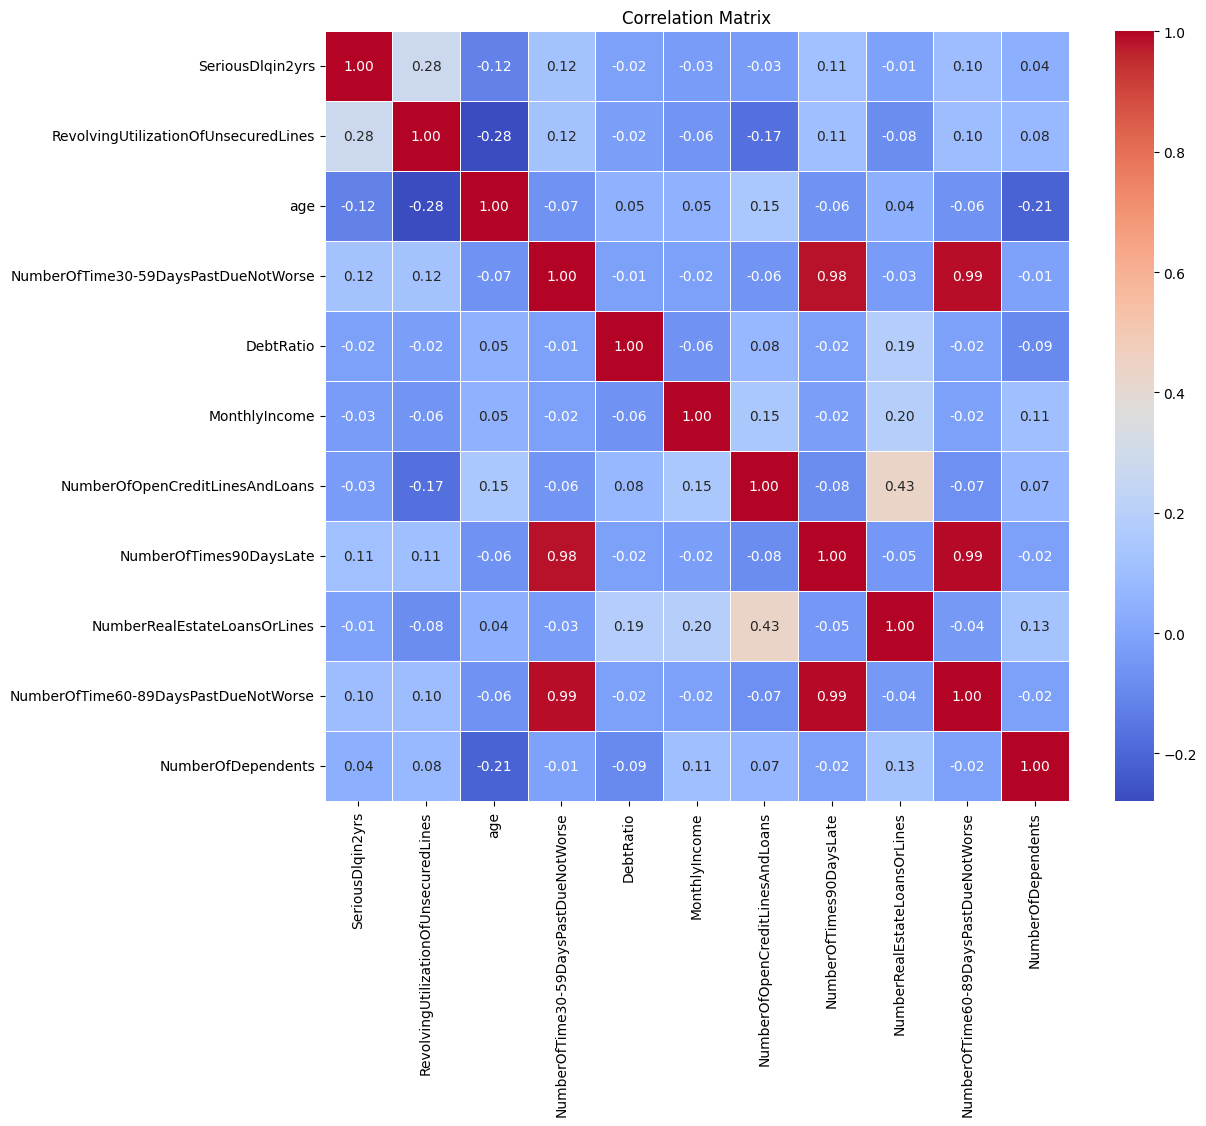


Features most correlated with target:
SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    0.277712
NumberOfTime30-59DaysPastDueNotWorse    0.120604
NumberOfTimes90DaysLate                 0.113803
NumberOfTime60-89DaysPastDueNotWorse    0.099451
NumberOfDependents                      0.038899
NumberRealEstateLoansOrLines           -0.013867
DebtRatio                              -0.017474
MonthlyIncome                          -0.030857
NumberOfOpenCreditLinesAndLoans        -0.034021
age                                    -0.115318
Name: SeriousDlqin2yrs, dtype: float64


In [13]:
plt.figure(figsize=(12, 10))
correlation_matrix = cs_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("\nFeatures most correlated with target:")
target_correlations = correlation_matrix['SeriousDlqin2yrs'].sort_values(ascending=False)
print(target_correlations)

# **Feature selection and Engineering**

### **Feature Engineering**

In [14]:

cs_train['Utilization_DebtRatio'] = cs_train['RevolvingUtilizationOfUnsecuredLines'] * cs_train['DebtRatio']
cs_train['Total_Past_Due'] = (cs_train['NumberOfTime30-59DaysPastDueNotWorse'] +
                                     cs_train['NumberOfTime60-89DaysPastDueNotWorse'] +
                                     cs_train['NumberOfTimes90DaysLate'])
cs_train['Age_Dependents_Ratio'] = cs_train['age'] / (cs_train['NumberOfDependents'] + 1)
cs_train['Credit_Per_Income'] = cs_train['NumberOfOpenCreditLinesAndLoans'] / (cs_train['MonthlyIncome'] + 1)
cs_train['Credit_Per_Person'] = cs_train['NumberOfOpenCreditLinesAndLoans'] / (cs_train['NumberOfDependents'] + 1)

# Log transformations to address skewness and potential non-linearity
cs_train['RevolvingUtilization_Log'] = np.log1p(cs_train['RevolvingUtilizationOfUnsecuredLines'])
cs_train['DebtRatio_Log'] = np.log1p(cs_train['DebtRatio'])
cs_train['MonthlyIncome_Log'] = np.log1p(cs_train['MonthlyIncome'])

print("New features created!")
for col in cs_train.columns:
    if col not in cs_train.columns:
        print(f"- {col}")


New features created!


### **Feature Selection using Wrapper**

In [15]:
X = cs_train.drop('SeriousDlqin2yrs', axis=1)
y = cs_train['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
lr = LogisticRegression(max_iter=1000, random_state=42)

sfs_forward = SFS(lr,
                 k_features=10,
                 forward=True,
                 floating=False,
                 scoring='roc_auc',
                 cv=5,
                 n_jobs=-1)

sfs_forward.fit(X_train, y_train)


SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000,
                                                       random_state=42),
                          k_features=(10, 10), n_jobs=-1, scoring='roc_auc')

In [17]:
forward_features = list(X_train.columns[list(sfs_forward.k_feature_idx_)])
print("Features selected by Forward Selection:")
for i, feature in enumerate(forward_features, 1):
    print(f"{i}. {feature}")


Features selected by Forward Selection:
1. RevolvingUtilizationOfUnsecuredLines
2. age
3. MonthlyIncome
4. NumberOfOpenCreditLinesAndLoans
5. NumberRealEstateLoansOrLines
6. NumberOfTime60-89DaysPastDueNotWorse
7. Utilization_DebtRatio
8. Total_Past_Due
9. Credit_Per_Income
10. RevolvingUtilization_Log


In [18]:
lr_rfe = LogisticRegression(max_iter=1000, random_state=42)

rfe = RFE(estimator=lr_rfe,
          n_features_to_select=10,
          step=1)

rfe.fit(X_train, y_train)

rfe_features = X_train.columns[rfe.support_].tolist()
print("Features selected by RFE:")
for i, feature in enumerate(rfe_features, 1):
    print(f"{i}. {feature}")

Features selected by RFE:
1. RevolvingUtilizationOfUnsecuredLines
2. NumberOfTime30-59DaysPastDueNotWorse
3. NumberOfTimes90DaysLate
4. NumberRealEstateLoansOrLines
5. NumberOfTime60-89DaysPastDueNotWorse
6. NumberOfDependents
7. Credit_Per_Income
8. Credit_Per_Person
9. RevolvingUtilization_Log
10. MonthlyIncome_Log


### **Regression Assumptions**

In [19]:

X_train_sm = sm.add_constant(X_train[rfe_features])
X_test_sm = sm.add_constant(X_test[rfe_features])

logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit(disp=0)

print("\nModel Summary:")
print(result.summary())



Model Summary:
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39989
Method:                           MLE   Df Model:                           10
Date:                Thu, 17 Apr 2025   Pseudo R-squ.:                  0.1636
Time:                        21:21:46   Log-Likelihood:                -8219.0
converged:                       True   LL-Null:                       -9827.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7154      0.213    -17.421      0.000      -4.133      -3.297
RevolvingUtilizationOfUnsecuredLines 

In [20]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))
print("\nFeatures with VIF > 10 may indicate multicollinearity issues.")


                                 Feature         VIF
1   RevolvingUtilizationOfUnsecuredLines  139.104469
9               RevolvingUtilization_Log  138.161751
5   NumberOfTime60-89DaysPastDueNotWorse  103.284285
0                                  const  100.682717
3                NumberOfTimes90DaysLate   80.982924
2   NumberOfTime30-59DaysPastDueNotWorse   44.988879
10                     MonthlyIncome_Log    2.149951
7                      Credit_Per_Income    2.058039
8                      Credit_Per_Person    1.579010
6                     NumberOfDependents    1.451389
4           NumberRealEstateLoansOrLines    1.232623

Features with VIF > 10 may indicate multicollinearity issues.


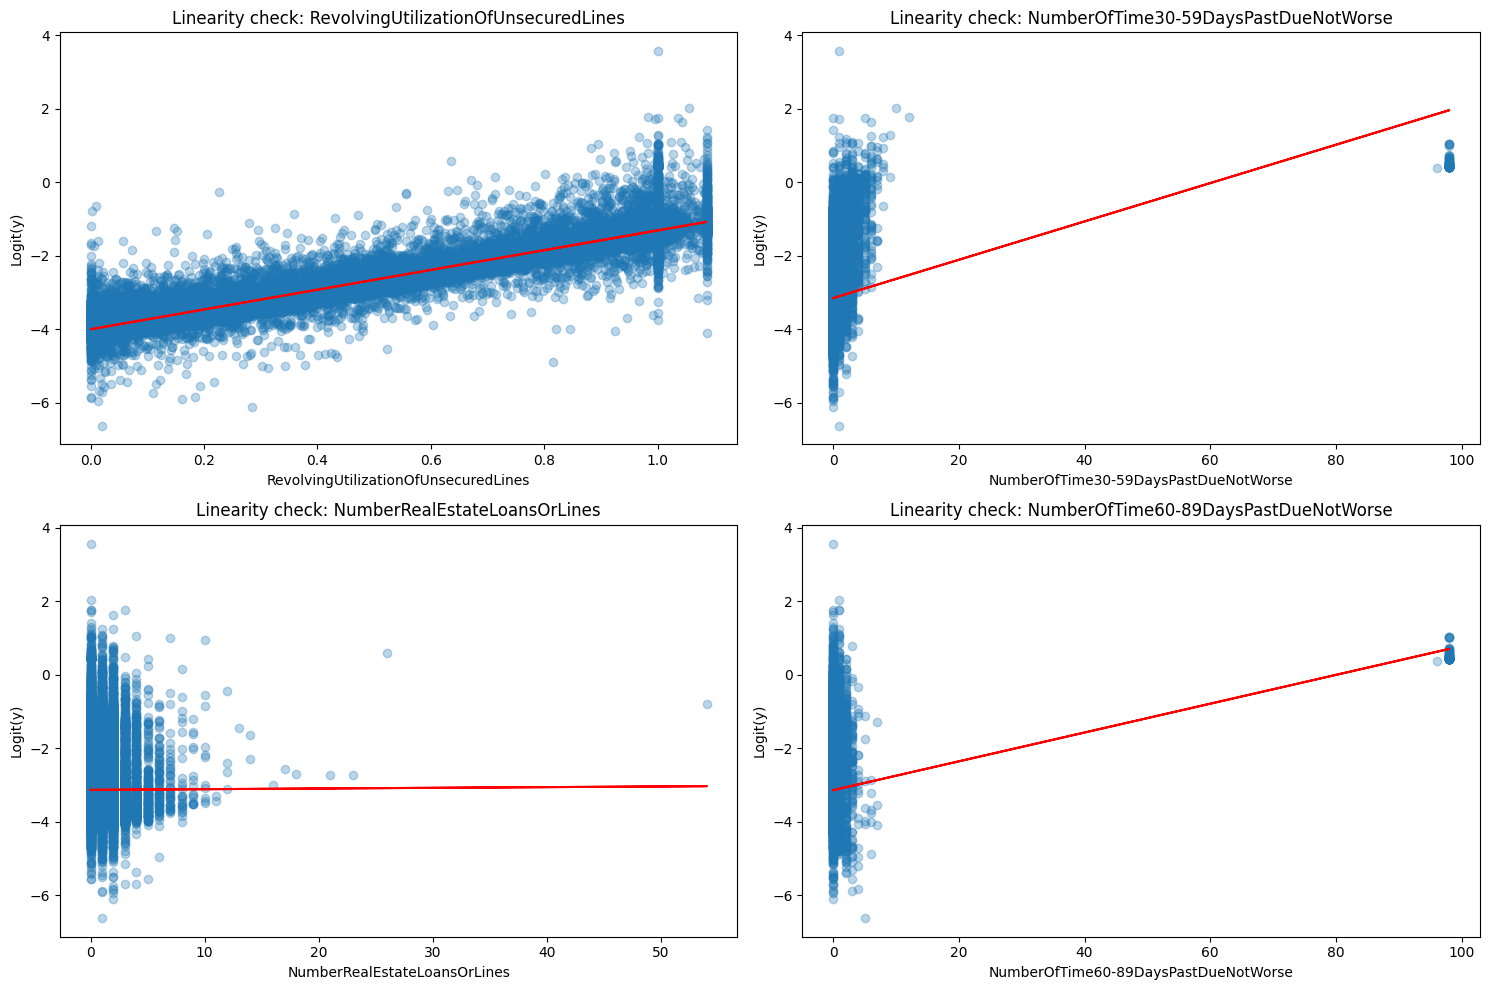

In [21]:
y_pred_proba = result.predict(X_train_sm)
logit_y = np.log(y_pred_proba / (1 - y_pred_proba))

continuous_features = [f for f in rfe_features if f not in ['NumberOfDependents', 'NumberOfTime30_59DaysPastDue',
                                                        'NumberOfTime60_89DaysPastDue', 'NumberOfTimes90DaysLate']]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features[:4], 1):
    plt.subplot(2, 2, i)
    plt.scatter(X_train[feature], logit_y, alpha=0.3)

    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(X_train[feature], logit_y)
    plt.plot(X_train[feature], intercept + slope*X_train[feature], 'r')

    plt.title(f'Linearity check: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Logit(y)')

plt.tight_layout()
plt.show()

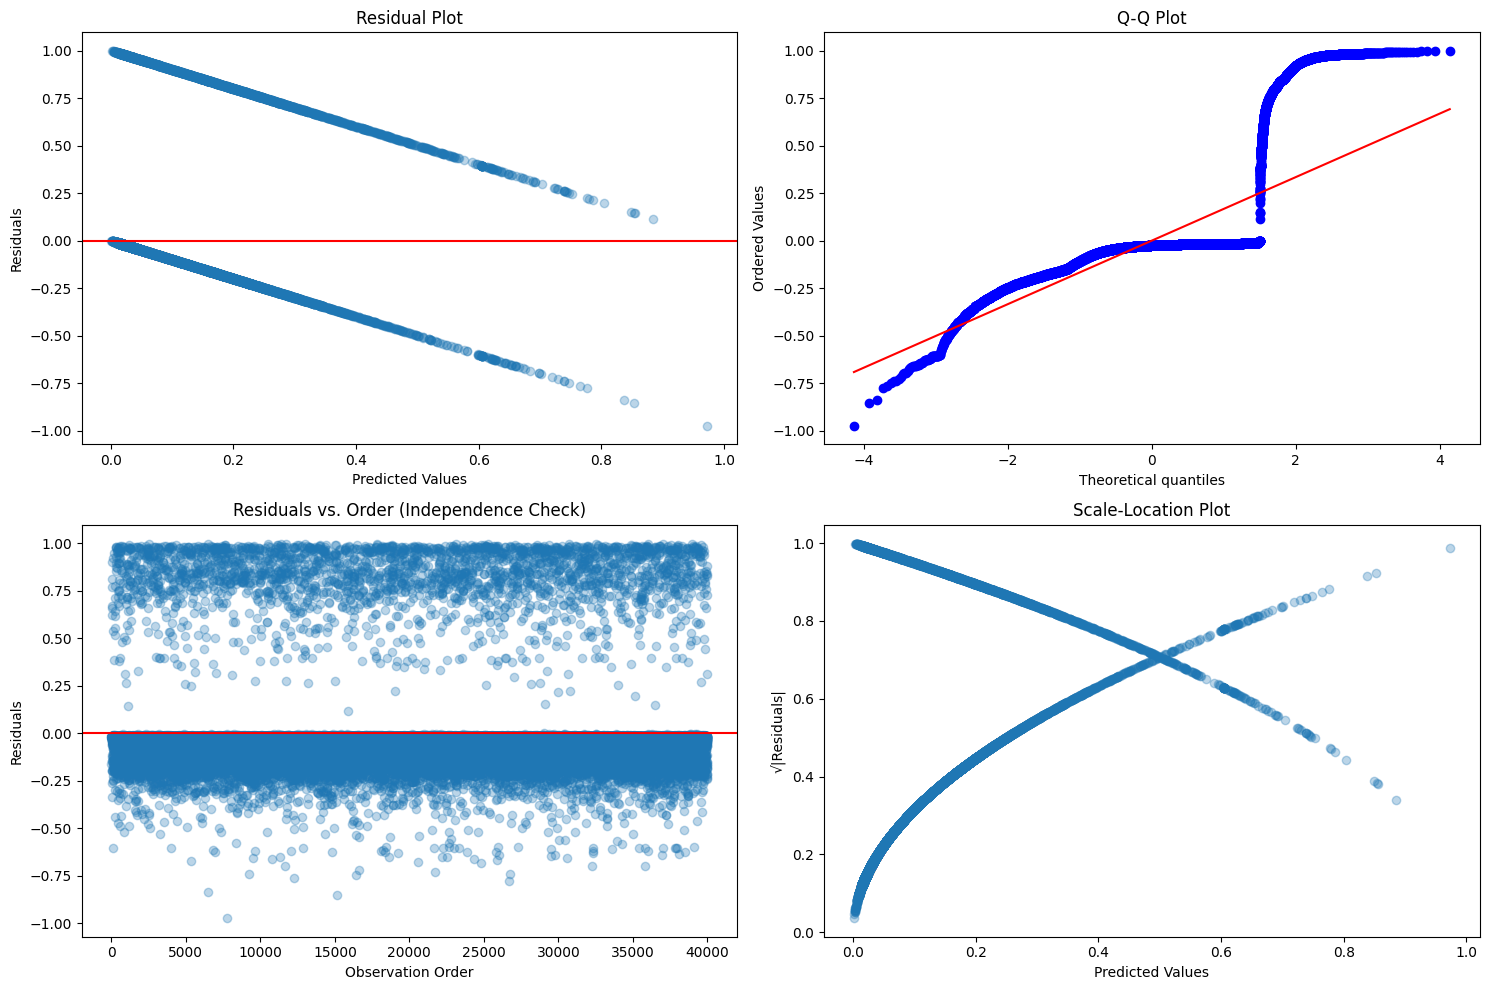

Statistic: 0.5059877505572117, p-value: 3.2718609252094987e-135
Residuals are not normally distributed (reject H0)
Durbin-Watson statistic: 1.9922009740740763
Value close to 2 suggests no autocorrelation
Value significantly less than 2 indicates positive autocorrelation
Value significantly greater than 2 indicates negative autocorrelation


In [22]:
y_pred = (y_pred_proba > 0.5).astype(int)
residuals = y_train - y_pred_proba
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(y_pred_proba, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.subplot(2, 2, 3)
plt.scatter(range(len(residuals)), residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Order (Independence Check)')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')

plt.subplot(2, 2, 4)
plt.scatter(y_pred_proba, np.sqrt(np.abs(residuals)), alpha=0.3)
plt.title('Scale-Location Plot')
plt.xlabel('Predicted Values')
plt.ylabel('√|Residuals|')

plt.tight_layout()
plt.show()

stat, p = shapiro(residuals)
print(f'Statistic: {stat}, p-value: {p}')
if p < 0.05:
    print("Residuals are not normally distributed (reject H0)")
else:
    print("Residuals appear to be normally distributed (fail to reject H0)")

dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')
print("Value close to 2 suggests no autocorrelation")
print("Value significantly less than 2 indicates positive autocorrelation")
print("Value significantly greater than 2 indicates negative autocorrelation")


### **Final Feature Selection**

In [23]:
final_features = [feature for feature in rfe_features if feature in vif_data[vif_data["VIF"] < 10]["Feature"].tolist()]

print(f"Final selected features ({len(final_features)}):")
for i, feature in enumerate(final_features, 1):
    print(f"{i}. {feature}")

X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print(f"\nFinal training data shape: {X_train_scaled.shape}")
print(f"Final testing data shape: {X_test_scaled.shape}")

Final selected features (5):
1. NumberRealEstateLoansOrLines
2. NumberOfDependents
3. Credit_Per_Income
4. Credit_Per_Person
5. MonthlyIncome_Log

Final training data shape: (40000, 5)
Final testing data shape: (10000, 5)


In [24]:
def eval(model, X_train, X_test, y_train, y_test, name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")
    print(f"Training AUC-ROC: {train_auc:.4f}")
    print(f"Testing AUC-ROC: {test_auc:.4f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    plt.figure(figsize=(8, 6))
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_test_proba)
    plt.plot(false_positive_rate, true_positive_rate, label=f'{name} (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()

    return {
        'model': model,
        'name': name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_auc': train_auc,
        'test_auc': test_auc
    }

# **Random Forest**

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

In [26]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

Training Accuracy: 0.9337
Testing Accuracy: 0.9327
Training AUC-ROC: 0.7606
Testing AUC-ROC: 0.6427

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      9331
           1       0.17      0.00      0.00       669

    accuracy                           0.93     10000
   macro avg       0.55      0.50      0.48     10000
weighted avg       0.88      0.93      0.90     10000



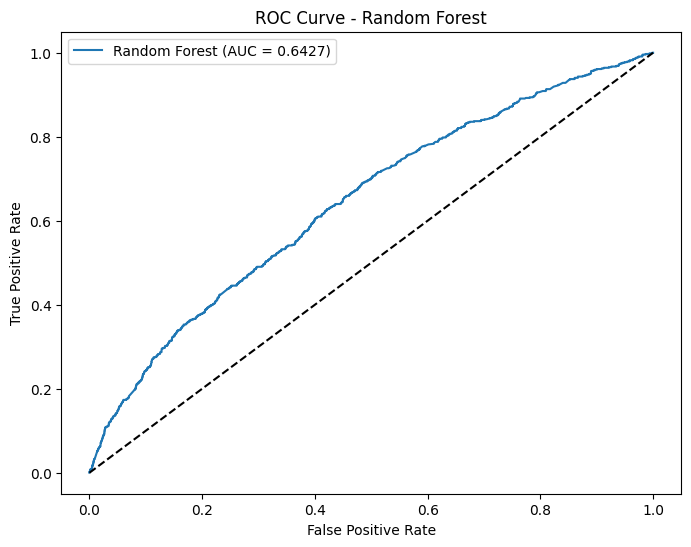

In [27]:
rf_results = eval(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")